# Working Ideas for Thesis Presentation

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import msprime
import tqdm

In [2]:
sns.set_context("talk")
sns.set_style("whitegrid")

In [3]:
tree = msprime.load("../results/sim51/tree_all.hdf")

In [4]:
tree_yri = msprime.load("../results/sim51/tree_YRI_GWAS_nofilt.hdf")

In [5]:
def compute_maf(path_tree):
    tree = msprime.load(path_tree)
    n_sites = tree.num_sites
    maf = []
    pbar = tqdm.tqdm(total=tree.num_sites)
    for variant in tree.variants():
        genos_diploid = return_diploid_genos(variant.genotypes,tree)
        freq = np.sum(genos_diploid,axis=1)/(2*genos_diploid.shape[1])
        if freq < 0.5: maf.append(freq)
        else: maf.append(1-freq)
        pbar.update(1)
    return maf

In [6]:
def return_diploid_genos(variant,tree):
    genos_diploid = np.sum(variant.reshape([1,int(tree.num_samples/2),2]),axis=-1)
    return genos_diploid

In [7]:
num_variants = len(np.loadtxt("../results/sim51/emp_prs/maf.txt"))
causal_inds = np.linspace(0, num_variants, 500, dtype=int,endpoint=False)
sum_stats_ceu = pd.read_csv("../results/sim51/emp_prs/comm_maf_0.01_sum_stats_m_500_h2_0.67.txt",sep="\t",index_col=0)
sum_stats_yri = pd.read_csv("../results/sim51/emp_prs/yri_comm_maf_0.01_sum_stats_m_500_h2_0.67.txt",sep="\t",index_col=0)

In [8]:
clumped_prs = np.loadtxt("../results/sim51/emp_prs/clumped_prs_vars_m_500_h2_0.67_ld_CEU_GWAS_r2_0.2_p0.01.txt")

In [9]:
# np.random.seed(53195)
# rand_choice = np.random.choice(causal_inds)
rand_choice = 224089

In [10]:
import threading,math

In [11]:
def find_ld_sites(tree_sequence,
                  focal_vars,
                  var2mut_dict,mut2var_dict,
                  max_distance=1e6,
                  r2_threshold=0,
                  num_threads=8):
    results = {}
    num_threads = min(num_threads, len(focal_vars))

    def thread_worker(thread_index):
        ld_calc = msprime.LdCalculator(tree_sequence)
        chunk_size = int(math.ceil(len(focal_vars) / num_threads))
        start = thread_index * chunk_size
        for focal_var in focal_vars[start: start + chunk_size]:
            focal_mutation = focal_var
            np.seterr(under='ignore')
            a = ld_calc.get_r2_array(
                focal_mutation, max_distance=max_distance,
                direction=msprime.REVERSE)
            a[np.isnan(a)] = 0
            rev_indexes = focal_mutation - np.nonzero(a >= r2_threshold)[0] - 1
            b = ld_calc.get_r2_array(
                focal_mutation, max_distance=max_distance,
                direction=msprime.FORWARD)
            b[np.isnan(b)] = 0
            print(b)
            print(focal_mutation)
            fwd_indexes = focal_mutation + np.nonzero(b >= r2_threshold)[0] + 1
            print(fwd_indexes)
            indexes = np.concatenate((rev_indexes[::-1], fwd_indexes))
#             indexes = [mut2var_dict.get(ind) for ind in indexes if mut2var_dict.get(ind)!=None]
            print(np.nonzero(a>=r2_threshold))
            r2_vals = list(b[::-1])+list(a)

            results[focal_mutation] = dict(zip(indexes,r2_vals))
    threads = [
    threading.Thread(target=thread_worker, args=(j,)) for j in range(num_threads)]
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    return results

In [4]:
s = msprime.simulate(100, recombination_rate=10, mutation_rate=20,
            random_seed=1)

In [5]:
ld_calc = msprime.LdCalculator(s)

In [6]:
ld_calc.get_r2_matrix()[1,2]

0.6767676767676769

In [7]:
ld_calc.get_r2_matrix()[2,1]

0.6767676767676769

In [8]:
focal_mutation = 0
max_distance=10
r2_threshold=0
np.seterr(under='ignore')
a = ld_calc.get_r2_array(
    focal_mutation, max_distance=max_distance,
    direction=msprime.REVERSE)
a[np.isnan(a)] = 0
a = a.copy()
rev_indexes = focal_mutation - np.nonzero(a >= r2_threshold)[0] - 1
b = ld_calc.get_r2_array(
    focal_mutation, max_distance=max_distance,
    direction=msprime.FORWARD)
b[np.isnan(b)] = 0
fwd_indexes = focal_mutation + np.nonzero(b >= r2_threshold)[0] + 1
indexes = np.concatenate((rev_indexes[::-1], fwd_indexes))


In [9]:
a

array([], dtype=float64)

In [10]:
b[0]

0.6144578313253012

In [11]:
b[0:5]

array([0.61445783, 0.4158452 , 0.0493167 , 0.61445783, 0.61445783])

In [12]:
a[::-1]

array([], dtype=float64)

In [13]:
b[0:5]

array([0.61445783, 0.4158452 , 0.0493167 , 0.61445783, 0.61445783])

In [15]:
focal_mutation = 1
max_distance=10
r2_threshold=0
np.seterr(under='ignore')
a = ld_calc.get_r2_array(
    focal_mutation, max_distance=max_distance,
    direction=msprime.REVERSE)
a[np.isnan(a)] = 0
rev_indexes = focal_mutation - np.nonzero(a >= r2_threshold)[0] - 1
b = ld_calc.get_r2_array(
    focal_mutation, max_distance=max_distance,
    direction=msprime.FORWARD)
b[np.isnan(b)] = 0
fwd_indexes = focal_mutation + np.nonzero(b >= r2_threshold)[0] + 1
indexes = np.concatenate((rev_indexes[::-1], fwd_indexes))

In [16]:
def get_dicts(tree_LD):
    var2mut, mut2var = {}, {}
    for mut in tree_LD.mutations():
        mut2var[mut.id]=mut.site
        var2mut[mut.site]=mut.id
    tree_LD_filt = tree_LD.simplify(filter_sites=True)
    return tree_LD_filt, var2mut, mut2var

In [ ]:
tree_ceu_ld, var2mut, mut2var = get_dicts(tree)
ld_struct = find_ld_sites(tree,[rand_choice],var2mut, mut2var,max_distance=1e3)

In [ ]:
ld_struct2_vars = list(ld_struct[rand_choice].keys())+[rand_choice]

In [ ]:
ld_struct2 = find_ld_sites(tree_ceu_ld, ld_struct2_vars, var2mut,mut2var,num_threads=16,max_distance=1e3)

In [ ]:
ceu_snps = []
ceu_r2 = []
for key,val in ld_struct.get(rand_choice).items():
    ceu_snps.append(key)
    ceu_r2.append(val)

In [ ]:
ld_mat = pd.DataFrame(index=ceu_snps,columns=ceu_snps)

In [ ]:
for ind in ld_mat.index:
    for col in ld_mat.columns: 
        if ind == col:
            ld_mat.loc[ind,col] = 1
        else:
            if ld_struct2[ind].get(col) != None:
                ld_mat.loc[ind,col] = ld_struct2[ind].get(col)
#                 ld_mat.loc[col,ind] = ld_struct2[ind].get(col)
ld_mat = ld_mat.fillna(0)

In [ ]:
sns.heatmap(ld_mat)

In [ ]:
ld_mat.loc[224053,224055]

In [ ]:
ld_mat.loc[224055,224053]

In [ ]:
ld_struct2.get(224053).get(224055)

In [ ]:
ld_struct2.get(224055).get(224053)

In [ ]:
ld_mat_all

In [ ]:
sns.heatmap(ld_mat_yri_all)

In [ ]:
inter = set(ld_mat.index).intersection(ld_mat_yri.index)

In [ ]:
sns.heatmap(ld_mat_yri.loc[inter,inter])

In [ ]:
sns.heatmap(ld_mat.loc[inter,inter])

In [ ]:
sub_ceu = sum_stats_ceu.reindex(ceu_snps+[rand_choice]).dropna()

In [ ]:
sub_yri = sum_stats_yri.reindex(yri_snps+[rand_choice]).dropna()

In [ ]:
af = pd.DataFrame(ceu_r2,index = ceu_snps)

In [ ]:
af_yri = pd.DataFrame(yri_r2,index= yri_snps)

In [ ]:
sub_ceu["LD"] = af.iloc[:,0]

In [ ]:
sub_yri["LD"] = af_yri.iloc[:,0]

In [ ]:
sub_ceu.loc[rand_choice,"LD"] =1
sub_yri.loc[rand_choice,"LD"] =1

In [ ]:
sub_ceu = sub_ceu.sort_index()
sub_yri = sub_yri.sort_index()

In [ ]:
sub_ceu.loc[rand_choice]

In [ ]:
sub_yri.loc[rand_choice]

In [ ]:
ceu_afs = mafs[sub_ceu.index]

In [ ]:
yri_afs = mafs_yri[sub_yri.index]

In [ ]:
fig,ax = plt.subplots(ncols=2,nrows=1,sharey=True,figsize=(20,5))
s = [10*100*n for n in ceu_afs]
ax[0].plot(sub_ceu.index,sub_ceu.OR,color="#178CCB",zorder=1,alpha=0.8)


ax[0].set_xticklabels("")
ax[0].set_title("European (CEU)",fontsize=28)
ax[0].vlines(rand_choice,sub_yri.OR.min(),sub_yri.OR.max(),linestyle="--",zorder=3)
# fig.colorbar(scat)
# ax[0].vlines(eur_selected,sub_yri.OR.min(),sub_yri.OR.max(),linestyle="-",zorder=2)
# s = [10*3**n for n in sub_yri.OR]
ax[1].plot(sub_yri.index,sub_yri.OR,color="#178CCB",zorder=1,alpha=0.8)

ax[1].set_xticklabels("")
ax[1].set_title("African (YRI)",fontsize=28)
ax[1].vlines(rand_choice,sub_yri.OR.min(),sub_yri.OR.max(),linestyle="--",zorder=2)
# ax[1].vlines(eur_selected,sub_yri.OR.min(),sub_yri.OR.max(),linestyle="-",zorder=2)

# fig.colorbar(scat)
fig.text(0.5, 0, 'Genetic Position', ha='center', va='center',fontsize=28)
fig.text(0, 0.5, 'Estimated Effect Size', ha='center', va='center',fontsize=28,rotation=90)
fig.text(0.5, 1, 'GWAS Estimates for SNPs within 1Mb of Causal Variant', ha='center', va='center',fontsize=28)
plt.tight_layout()
# plt.savefig("/Users/taylorcavazos/Desktop/genetic_position_es.png",dpi=800,bbox_inches="tight")
plt.show()

In [ ]:
sub_ceu["COLOR"]

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
sns.heatmap(sub_yri[["LD"]].T,vmax=0.4)
fig.tight_layout()
plt.show()

In [ ]:
sub_ceu.loc[sub_ceu["LD"]>=0.8,"COLOR"] = "#e31a1c"
sub_ceu.loc[(sub_ceu["LD"]<0.8)&(sub_ceu["LD"]>=0.6),"COLOR"] = "#ff7f00"
sub_ceu.loc[(sub_ceu["LD"]<0.6)&(sub_ceu["LD"]>=0.4),"COLOR"] = "#b2df8a"
sub_ceu.loc[(sub_ceu["LD"]<0.4)&(sub_ceu["LD"]>=0.2),"COLOR"] = "#a6cee3"
sub_ceu.loc[sub_ceu["LD"]<0.2,"COLOR"] = "#1f78b4"

In [ ]:
sub1 = sub_ceu[sub_ceu["LD"]>=0.8]
sub2 =sub_ceu[(sub_ceu["LD"]<0.8)&(sub_ceu["LD"]>=0.6)]
sub3 =sub_ceu[(sub_ceu["LD"]<0.6)&(sub_ceu["LD"]>=0.4)]
sub4 =sub_ceu[(sub_ceu["LD"]<0.4)&(sub_ceu["LD"]>=0.2)]
sub5 =sub_ceu[sub_ceu["LD"]<0.2]

In [ ]:
sub1

In [ ]:
from pylab import *

cmap = cm.get_cmap('Paired')    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))

In [19]:
import msprime

def get_ld(mutations):
    results = {}
    for focal_mutation in mutations:
        a = ld_calc.r2_array(
        focal_mutation, max_distance=10,
        direction=msprime.REVERSE)
        rev_indexes = focal_mutation - np.nonzero(a >= 0)[0] - 1
        a = a.copy()
        b = ld_calc.r2_array(
            focal_mutation, max_distance=10,
            direction=msprime.FORWARD)
        fwd_indexes = focal_mutation + np.nonzero(b >= 0)[0] + 1
        indexes = np.concatenate((rev_indexes[::-1], fwd_indexes))
        r2_vals = list(a[::-1])+list(b)
        results[focal_mutation] = dict(zip(indexes,r2_vals))
    return results

ts = msprime.simulate(100, recombination_rate=10, mutation_rate=20, random_seed=1)
ld_calc = msprime.LdCalculator(ts)
results = get_ld([1,2])

ld_1_2, ld_2_1 = results.get(1).get(2), results.get(2).get(1) 

print("LD between variant 1 and variant 2 = {}".format(ld_1_2))
print("LD between variant 2 and variant 1 = {}".format(ld_2_1))
print("Absolute difference = {}".format(abs(ld_1_2-ld_2_1)))

LD between variant 1 and variant 2 = 0.6767676767676769
LD between variant 2 and variant 1 = 0.6767676767676769
Absolute difference = 0.0


In [8]:
ld_mat = ld_calc.get_r2_matrix()
ld_mat[1,2] == ld_mat[2,1]

True

In [9]:
ld_mat[1,2]

0.6767676767676769

In [10]:
ld_mat[2,1]

0.6767676767676769

In [11]:
focal_mutation0 = 1
focal_mutation1 = 2

a0 = ld_calc.get_r2_array(
    focal_mutation0, max_distance=10,
    direction=msprime.REVERSE)
rev_indexes0 = focal_mutation0 - np.nonzero(a0 >= 0)[0] - 1
b0 = ld_calc.get_r2_array(
    focal_mutation0, max_distance=10,
    direction=msprime.FORWARD)
fwd_indexes0 = focal_mutation0 + np.nonzero(b0 >= 0)[0] + 1
indexes0 = np.concatenate((rev_indexes0[::-1], fwd_indexes0))
r2_vals0 = list(a0[::-1])+list(b0)

dict0 = dict(zip(indexes0, r2_vals0))

a1 = ld_calc.get_r2_array(
    focal_mutation1, max_distance=10,
    direction=msprime.REVERSE)
rev_indexes1 = focal_mutation1 - np.nonzero(a1 >= 0)[0] - 1
b1 = ld_calc.get_r2_array(
    focal_mutation1, max_distance=10,
    direction=msprime.FORWARD)
fwd_indexes1 = focal_mutation1 + np.nonzero(b1 >= 0)[0] + 1
indexes1= np.concatenate((rev_indexes1[::-1], fwd_indexes1))
r2_vals1 = list(a1[::-1])+list(b1)

dict1 = dict(zip(indexes1, r2_vals1))

dict0.get(1) == dict1.get(0)

False

In [17]:
def get_ld(focal_mutation):
    a = ld_calc.get_r2_array(
    focal_mutation, max_distance=1e6,
    direction=msprime.REVERSE)
    rev_indexes = focal_mutation - np.nonzero(a >= 0)[0] - 1
    a = a.copy()
    b = ld_calc.get_r2_array(
        focal_mutation, max_distance=1e6,
        direction=msprime.FORWARD)
    fwd_indexes = focal_mutation + np.nonzero(b >= 0)[0] + 1
    indexes = np.concatenate((rev_indexes[::-1], fwd_indexes))
    r2_vals = list(a[::-1])+list(b)
    return dict(zip(indexes,r2_vals))

In [18]:
ts.num_sites

NameError: name 'ts' is not defined

In [8]:
dict_overall = {}
for var in ts.variants():
    dict_overall[var.site.id] = get_ld(var.site.id)

In [9]:
for key in dict_overall.keys():
    if len(dict_overall.get(key)) != 406:
        print(key)

In [10]:
diffs = {}
for var1 in tqdm.tqdm(range(ts.num_sites)):
    for var2 in range(ts.num_sites):
        if var1 != var2:
            ld1 = dict_overall.get(var1).get(var2)
            ld2 = dict_overall.get(var2).get(var1)
            diff = np.absolute(ld1 - ld2)
            vars_sort = sorted([var1,var2])
            if (vars_sort[0],vars_sort[1]) not in diffs.keys():                
                diffs[(vars_sort[0],vars_sort[1])] = diff

100%|██████████| 407/407 [00:00<00:00, 1003.58it/s]


In [11]:
len(diffs)

82621

In [49]:
(407*407)/2

82824.5

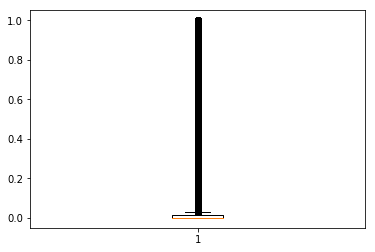

In [77]:
plt.boxplot(list(diffs.values()))
plt.show()

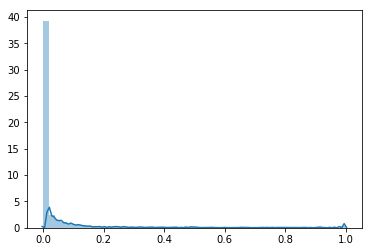

In [79]:
sns.distplot(list(diffs.values()))

In [12]:
pos = {}
for var in ts.variants():
    pos[var.site.id] = var.site.position

In [23]:
pos

{0: 0.002672946369321955,
 1: 0.0039364623415239245,
 2: 0.006702985403230572,
 3: 0.008293546463786917,
 4: 0.011258158537187297,
 5: 0.011901766152571222,
 6: 0.012944254682954306,
 7: 0.013289122156479377,
 8: 0.0194264688836185,
 9: 0.01970296219150547,
 10: 0.02096817317638017,
 11: 0.021103099230185683,
 12: 0.02337006409652531,
 13: 0.025480305036262554,
 14: 0.026299754812831224,
 15: 0.028760486836320015,
 16: 0.02928403317554266,
 17: 0.03215281253151962,
 18: 0.03351230726554964,
 19: 0.035660018966218274,
 20: 0.03841658214129394,
 21: 0.03926060065904584,
 22: 0.040454492299915074,
 23: 0.04180406654946376,
 24: 0.05095349599810321,
 25: 0.05119927417713746,
 26: 0.05295730452053249,
 27: 0.05360292403876699,
 28: 0.06789033318243737,
 29: 0.07698983000904573,
 30: 0.08039328813614445,
 31: 0.09247168445906456,
 32: 0.09309508411266179,
 33: 0.09929297855172059,
 34: 0.09932060624467182,
 35: 0.10922949924656083,
 36: 0.1130971231483172,
 37: 0.11471929420345192,
 38: 0.12

In [15]:
pos_diffs = []
for key in diffs.keys():
    var1,var2 = key
    pos1,pos2 = pos.get(var1), pos.get(var2)
    pos_diff = np.absolute(pos1-pos2)
    pos_diffs.append(pos_diff)

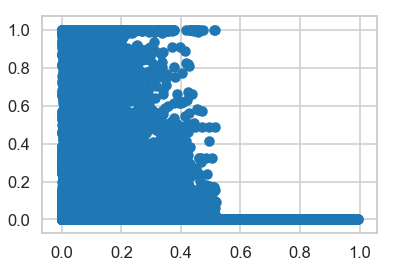

In [17]:
plt.scatter(x=pos_diffs,y=list(diffs.values()))
plt.show()

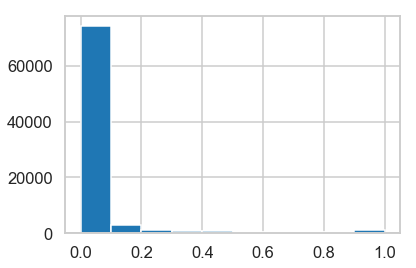

In [21]:
plt.hist(list(diffs.values()))
plt.show()

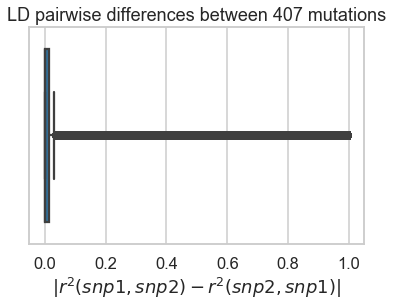

In [47]:
sns.boxplot(list(diffs.values()))
plt.xlabel("$|r^2(snp1,snp2) - r^2(snp2,snp1)|$")
plt.title("LD pairwise differences between 407 mutations")
plt.savefig("/Users/taylorcavazos/Box Sync/LD_diffs.png",bbox_inches="tight")
plt.show()

In [42]:
vals = np.array(list(diffs.values()))

In [55]:
len(vals[vals<0.01])

60399

KeyboardInterrupt: 

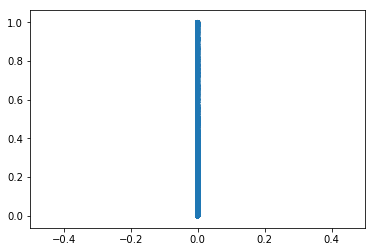

In [74]:
sns.swarmplot(y=list(diffs.values()))
plt.show()

In [100]:
dict1.get(1)

0.02050811141720233

In [104]:
msprime.__version__

'0.7.0'

In [102]:
dict0

{0: 0.6767676767676769,
 2: 0.6767676767676769,
 3: 0.030303030303030304,
 4: 1.0,
 5: 1.0,
 6: 0.061224489795918366,
 7: 1.0,
 8: 0.028985507246376812,
 9: 0.010309278350515465,
 10: 1.0,
 11: 0.01388888888888889,
 12: 0.030303030303030304,
 13: 0.02508960573476703,
 14: 1.0,
 15: 1.0,
 16: 0.010309278350515465,
 17: 0.028985507246376812,
 18: 0.2608695652173913,
 19: 1.0,
 20: 0.2608695652173913,
 21: 0.030303030303030304,
 22: 1.0,
 23: 0.0033670033670033673,
 24: 0.01388888888888889,
 25: 0.028985507246376812,
 26: 0.006802721088435375,
 27: 0.030303030303030304,
 28: 0.01388888888888889,
 29: 0.6144578313253012,
 30: 0.32871111111111107,
 31: 0.5294117647058824,
 32: 0.037037037037037035,
 33: 0.0033670033670033673,
 34: 0.3983739837398372,
 35: 0.3983739837398372,
 36: 0.02508960573476703,
 37: 0.3983739837398372,
 38: 0.3983739837398373,
 39: 0.028985507246376812,
 40: 0.3983739837398372,
 41: 0.125,
 42: 0.061224489795918366,
 43: 0.2491694352159467,
 44: 0.0033670033670033673,

In [101]:
dict1

{0: 0.6767676767676769,
 1: 0.02050811141720233,
 3: 0.02050811141720233,
 4: 0.6767676767676769,
 5: 0.6767676767676769,
 6: 0.04143475572047002,
 7: 0.6767676767676769,
 8: 0.17654808959156787,
 9: 0.015233112786582551,
 10: 0.6767676767676769,
 11: 0.020522388059701493,
 12: 0.02050811141720233,
 13: 0.037072701011073676,
 14: 0.6767676767676769,
 15: 0.6767676767676767,
 16: 0.015233112786582551,
 17: 0.17654808959156787,
 18: 0.17654808959156787,
 19: 0.6767676767676769,
 20: 0.17654808959156787,
 21: 0.02050811141720233,
 22: 0.6767676767676769,
 23: 0.004975124378109453,
 24: 0.020522388059701493,
 25: 0.17654808959156787,
 26: 0.010051781906792569,
 27: 0.02050811141720233,
 28: 0.020522388059701493,
 29: 0.41584519897772926,
 30: 0.6767676767676767,
 31: 0.358288770053476,
 32: 0.05472636815920399,
 33: 0.004975124378109453,
 34: 0.25152507970127197,
 35: 0.25152507970127197,
 36: 0.037072701011073676,
 37: 0.25152507970127197,
 38: 0.25152507970127197,
 39: 0.0428293316028552